In [2]:
import pandas as pd
import os
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
import yaml

with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

pd.read_csv(config["input_data"]["file2"])
#df.to_csv(config["output_data"]["file2"])

SyntaxError: incomplete input (129782250.py, line 7)

In [5]:

nlp = spacy.load("en_core_web_sm")


## Clean column name by lower and replace white space

In [ ]:
# sentiment_df
# co_ai_adop_df
# occu_gro_df
# occ_w_df

In [6]:
#REDDIT COMMENTS AKA ai job sentiment
file_p= r'../data/raw/reddit_comments_combined.csv'
sentiment_df= pd.read_csv(file_p)
sentiment_df.head()

,Post ID,Post Title,Comment ID,Comment Author,Comment Score,Comment Body,Comment Created
0,17i2fhi,Are you guys worried that AI will take your job?,k6rs0pq,Thisbymaster,26,Try getting GitHub copilot to build a function...,1698461647
1,17i2fhi,Are you guys worried that AI will take your job?,k6rg2pa,usernames_suck_ok,39,The fact that employers don't want people to w...,1698455954
2,17i2fhi,Are you guys worried that AI will take your job?,k6ruz4g,ponzi_pyramid_digdug,18,Sometimes. Then I see what ai can output and d...,1698463171
3,17i2fhi,Are you guys worried that AI will take your job?,k6rfq8z,Battosai_Kenshin99,88,I do not understand people's fear of AI. Imagi...,1698455791
4,17i2fhi,Are you guys worried that AI will take your job?,k6rt4lj,Excuse_my_GRAMMER,7,Not really lol AI is just another tool \n\nI t...,1698462202


In [7]:
sentiment_df.shape

(885, 7)

In [8]:
sentiment_df.columns = sentiment_df.columns.str.replace(' ', '_').str.lower()
sentiment_df = sentiment_df.replace(r'\s+', '_', regex=True)

In [9]:
# View nulls  Sentiment
print("Missing values per column:\n", sentiment_df.isnull().sum())

Missing values per column:
 post_id             0
post_title          0
comment_id          0
comment_author     89
comment_score       0
comment_body        0
comment_created     0
dtype: int64


In [10]:
 for col in sentiment_df.columns:
    if sentiment_df[col].isnull().sum() == 0:
        continue  # Skip columns with no missing values
    
    if sentiment_df[col].dtype == 'object':
        mode_val = sentiment_df[col].mode()
        if not mode_val.empty:
            sentiment_df[col] = sentiment_df[col].fillna(mode_val[0])
        else:
            sentiment_df[col] = sentiment_df[col].fillna("unknown")  # fallback
    else:
        mean_val = sentiment_df[col].mean()
        sentiment_df[col] = sentiment_df[col].fillna(mean_val)

In [11]:
#fill nan values of sentiment
sentiment_df['comment_author'] = sentiment_df['comment_author'].fillna('anonymous')


In [12]:
# Remove duplicates
sentiment_df = sentiment_df.drop_duplicates().reset_index(drop=True)

In [13]:
print("Remaining nulls:\n", sentiment_df.isnull().sum())


Remaining nulls:
 post_id            0
post_title         0
comment_id         0
comment_author     0
comment_score      0
comment_body       0
comment_created    0
dtype: int64


In [14]:
#  Drop duplicates and reset index
sentiment_df = sentiment_df.drop_duplicates().reset_index(drop=True)


In [15]:
sentiment_df = sentiment_df.drop(['post_id', 'comment_created'], axis=1)


In [16]:
sentiment_df.columns

Index(['post_title', 'comment_id', 'comment_author', 'comment_score',
       'comment_body'],
      dtype='object')

In [17]:
sentiment_df.dtypes

post_title        object
comment_id        object
comment_author    object
comment_score      int64
comment_body      object
dtype: object

In [18]:
print("Final shape:", sentiment_df.shape)

Final shape: (885, 5)


In [19]:
sentiment_df['comment_body'] = sentiment_df['comment_body'].astype(str)

In [20]:
nlp = spacy.load("en_core_web_sm")


In [21]:
# sentiment words list
positive_words = {
    'safe', 'secure', 'confident', 'optimistic', 'opportunity', 'creative', 
    'valuable', 'promising', 'empowered', 'supportive', 'hopeful', 'excited','good', 'great', 
    'helpful', 'smart', 'efficient', 'love', 'amazing', 'brilliant'
}

negative_words = {
    'worried', 'afraid', 'fear', 'replace', 'jobless', 'redundant', 
    'useless', 'anxious', 'threatened', 'concerned', 'scared', 'depressed',
    'bad', 'terrible', 'useless', 'dumb', 'hate', 'annoying', 'slow', 'stupid'
}


In [22]:
def analyze_sentiment_spacy(comment):
    doc = nlp(comment.lower())
    pos_count = sum(token.text in positive_words for token in doc)
    neg_count = sum(token.text in negative_words for token in doc)
    
    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

sentiment_df['sentiment'] = sentiment_df['comment_body'].apply(analyze_sentiment_spacy)


In [23]:
print(sentiment_df['sentiment'].value_counts())


sentiment
neutral     884
negative      1
Name: count, dtype: int64


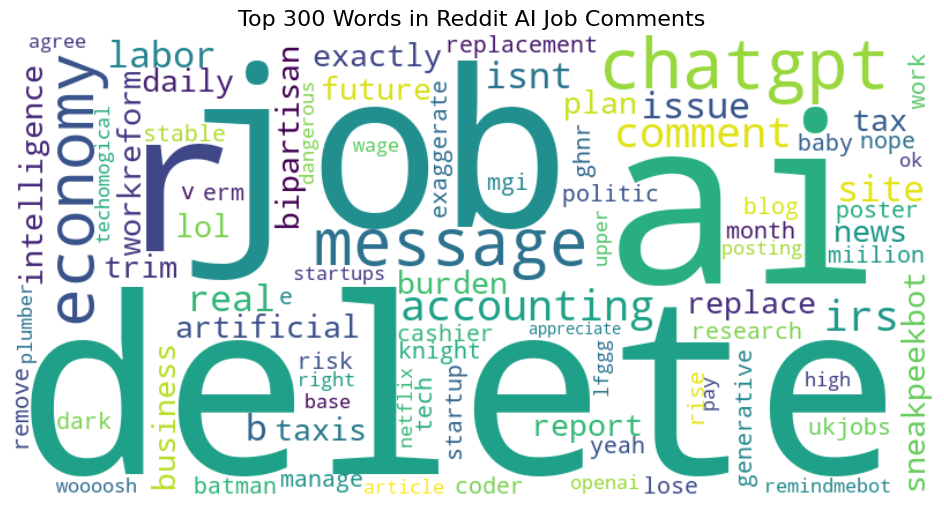

In [28]:
# Combine all comments into one string
all_text = ' '.join(sentiment_df['comment_body'].dropna().tolist()).lower()

# Tokenize with spaCy and filter for actual words (no punctuation/numbers/stop words)
#Create a list of "clean" words:
#    - is_alpha: only keep words (no numbers or punctuation)
#    - not token.is_stop: remove common words like "the", "and", "is", etc.
#    - token.lemma_: get the base form of each word (e.g., "working" → "work")
doc = nlp(all_text)
tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

# Count the top words
word_freq = Counter(tokens).most_common(300)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 300 Words in Reddit AI Job Comments', fontsize=16)
# Displaying the plot
plt.savefig("../slides/visuals/Top 300 Words in Reddit AI Job Comments.png", transparent=True, format="png")
plt.show()

## CLEANING OF EMPLOYMENT PROJECTIONS

In [ ]:
import pandas as pd

In [ ]:
# Employment_projections = pd.read_csv(r'..\data\raw\Employment_projections.csv')



In [ ]:
# # 1. Clean column names
# Employment_projections.columns = Employment_projections.columns.str.lower().str.replace(" ", "_").str.strip()

In [ ]:
# 2. View nulls
# print("Missing values per column:\n", Employment_projections.isnull().sum())

In [ ]:
# print(df.columns.tolist())



In [ ]:
# df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(",", "").str.strip()
# print(df.columns.tolist())


In [ ]:
# df['work_experience_in_a_related_occupation'] = df['work_experience_in_a_related_occupation'].fillna('Not Required')


In [ ]:
#df['typical_on-the-job_training'] = df['typical_on-the-job_training'].fillna('None')
 

In [ ]:
# Employment_projections.to_csv(r'..\data\clean\Employment_projection.csv', index=False, encoding='utf-8', sep=";")

## CLEANING OF OCCUPATION GROWTH

In [29]:
#READ data occupation growth
import os
folder_path = r'../data/raw'
matrix_files = [
    "National_Employment_Matrix_IND_31-330.csv",
    "National_Employment_Matrix_IND_230000.csv",
    "National_Employment_Matrix_IND_541200.csv",
    "National_Employment_Matrix_IND_541300.csv",
    "National_Employment_Matrix_IND_610000.csv",
    "National_Employment_Matrix_IND_710000.csv",
    "National_Employment_Matrix_IND_721000.csv",
    "National_Employment_Matrix_OCC_39-3011.csv"
]

# Load and combine all matrix datasets
matrix_dfs = []
for file in matrix_files:
    path = os.path.join(folder_path, file)
    occu_gro_df = pd.read_csv(path, on_bad_lines='skip')  # Skip broken lines
    occu_gro_df['source_file'] = file  # Track origin
    matrix_dfs.append(occu_gro_df)

# Merge into one dataframe
occu_gro_df = pd.concat(matrix_dfs, ignore_index=True)
print("Employment matrix shape:", occu_gro_df.shape)
occu_gro_df.head(5)

# occu_gro_df= pd.read_csv(r'..\data\clean\occupation_growth.csv')
# occu_gro_df.head()

Employment matrix shape: (3834, 18)


,Occupation Title,Occupation Code,Occupation Type,2023 Employment,2023 Percent of Industry,2023 Percent of Occupation,Projected 2033 Employment,Projected 2033 Percent of Industry,Projected 2033 Percent of Occupation,"Employment Change, 2023-2033","Employment Percent Change, 2023-2033",Occupation Sort,Display Level,source_file,Industry Title,Industry Code,Industry Type,Industry Sort
0,"Total, all occupations","=""00-0000""",Summary,"12,939.5",100.0,7.7,"13,049.5",100.0,7.5,110.0,0.8,NaN,0,National_Employment_Matrix_IND_31-330.csv,NaN,NaN,NaN,NaN
1,Management occupations,"=""11-0000""",Summary,857.7,6.6,6.5,889.8,6.8,6.3,32.0,3.7,2.0,1,National_Employment_Matrix_IND_31-330.csv,NaN,NaN,NaN,NaN
2,Top executives,"=""11-1000""",Summary,273.6,2.1,6.9,279.5,2.1,6.6,5.8,2.1,3.0,2,National_Employment_Matrix_IND_31-330.csv,NaN,NaN,NaN,NaN
3,Chief executives,"=""11-1011""",Line Item,12.7,0.1,4.0,13.1,0.1,4.0,0.4,3.2,4.0,3,National_Employment_Matrix_IND_31-330.csv,NaN,NaN,NaN,NaN
4,General and operations managers,"=""11-1021""",Line Item,260.9,2.0,7.2,266.4,2.0,6.9,5.4,2.1,5.0,3,National_Employment_Matrix_IND_31-330.csv,NaN,NaN,NaN,NaN


In [30]:
# 2. Clean column names
occu_gro_df.columns = (
    occu_gro_df.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(",", "")
    .str.strip()
)

In [31]:
print(occu_gro_df.columns.tolist())


['occupation_title', 'occupation_code', 'occupation_type', '2023_employment', '2023_percent_of_industry', '2023_percent_of_occupation', 'projected_2033_employment', 'projected_2033_percent_of_industry', 'projected_2033_percent_of_occupation', 'employment_change_2023-2033', 'employment_percent_change_2023-2033', 'occupation_sort', 'display_level', 'source_file', 'industry_title', 'industry_code', 'industry_type', 'industry_sort']


In [32]:
# Drop duplicates and reset index
occu_gro_df = occu_gro_df.drop_duplicates().reset_index(drop=True)

In [33]:
occu_gro_df.columns


Index(['occupation_title', 'occupation_code', 'occupation_type',
       '2023_employment', '2023_percent_of_industry',
       '2023_percent_of_occupation', 'projected_2033_employment',
       'projected_2033_percent_of_industry',
       'projected_2033_percent_of_occupation', 'employment_change_2023-2033',
       'employment_percent_change_2023-2033', 'occupation_sort',
       'display_level', 'source_file', 'industry_title', 'industry_code',
       'industry_type', 'industry_sort'],
      dtype='object')

In [34]:
occu_gro_df = occu_gro_df.loc[:, ['occupation_title', 'occupation_code', '2023_employment', 'projected_2033_employment','employment_percent_change_2023-2033','employment_change_2023-2033']]

In [35]:
occu_gro_df.head(10)

,occupation_title,occupation_code,2023_employment,projected_2033_employment,employment_percent_change_2023-2033,employment_change_2023-2033
0,"Total, all occupations","=""00-0000""","12,939.5","13,049.5",0.8,110.0
1,Management occupations,"=""11-0000""",857.7,889.8,3.7,32.0
2,Top executives,"=""11-1000""",273.6,279.5,2.1,5.8
3,Chief executives,"=""11-1011""",12.7,13.1,3.2,0.4
4,General and operations managers,"=""11-1021""",260.9,266.4,2.1,5.4
5,"Advertising, marketing, promotions, public rel...","=""11-2000""",94.0,97.5,3.7,3.5
6,Advertising and promotions managers,"=""11-2011""",0.5,0.5,-13.0,-0.1
7,Marketing and sales managers,"=""11-2020""",91.6,95.1,3.8,3.5
8,Marketing managers,"=""11-2021""",29.6,30.9,4.5,1.3
9,Sales managers,"=""11-2022""",62.0,64.2,3.5,2.2


In [36]:
occu_gro_df.dtypes

occupation_title                        object
occupation_code                         object
2023_employment                         object
projected_2033_employment               object
employment_percent_change_2023-2033    float64
employment_change_2023-2033            float64
dtype: object

In [37]:
# Remove commas and convert to float
occu_gro_df['2023_employment'] = occu_gro_df['2023_employment'].str.replace(',', '').astype(float)
occu_gro_df['projected_2033_employment'] = occu_gro_df['projected_2033_employment'].str.replace(',', '').astype(float)

occu_gro_df['occupation_code'].astype(str)

0       ="00-0000"
1       ="11-0000"
2       ="11-1000"
3       ="11-1011"
4       ="11-1021"
           ...    
3829           nan
3830           nan
3831           nan
3832           nan
3833           nan
Name: occupation_code, Length: 3834, dtype: object

## CLEANING  OF OCCUPATION WAGE

In [38]:
#READ data occupation wages

import csv

# Reload the re-uploaded file after reset
file_path =r'../data/raw/all_data_M_2024.csv'

# Attempt to load while skipping problematic lines
try:
    occ_w_df = pd.read_csv(
        file_path,
        quoting=csv.QUOTE_MINIMAL,
        encoding='utf-8',
        on_bad_lines='skip'  # skips problematic lines
    )
    cleaned_preview = occ_w_df.head()
except Exception as e:
    cleaned_preview = f"Error during loading: {e}"

cleaned_preview
# Reload the file using semicolon delimiter
occ_w_df = pd.read_csv(file_path, delimiter=';', encoding='utf-8', on_bad_lines='skip')

# Show the cleaned preview
occ_w_df.head()

/var/folders/v_/rkcyqdxx47vbjgvjddywrbrh0000gn/T/ipykernel_40286/1802939830.py:22: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  occ_w_df = pd.read_csv(file_path, delimiter=';', encoding='utf-8', on_bad_lines='skip')


,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,"23,80","37,89","60,44",29.990,36.730,49.500,78.810,125.720,NaN,NaN
1,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,"58,70","82,50",#,57.010,79.900,122.090,171.610,#,NaN,NaN
2,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1000,Top Executives,...,"50,48","81,01",#,47.510,68.800,104.990,168.490,#,NaN,NaN
3,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1010,Chief Executives,...,"99,24",#,#,73.710,126.080,206.420,#,#,NaN,NaN
4,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,"99,24",#,#,73.710,126.080,206.420,#,#,NaN,NaN


In [39]:
 #2. Clean column names
occ_w_df.columns = (
    occ_w_df.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(",", "")
    .str.strip()
)


In [40]:
# 3. Print missing values for review
print("Missing values before cleaning:\n", occ_w_df.isnull().sum())


Missing values before cleaning:
 area                0
area_title          0
area_type           0
prim_state          0
naics               0
naics_title         0
i_group             0
own_code            0
occ_code            0
occ_title           0
o_group             0
tot_emp             0
emp_prse            0
jobs_1000       65535
loc_quotient    65535
pct_total        2787
pct_rpt          2787
h_mean              0
a_mean              0
mean_prse           0
h_pct10             0
h_pct25             0
h_median            0
h_pct75             0
h_pct90             0
a_pct10             0
a_pct25             0
a_median            0
a_pct75             0
a_pct90             0
annual          64941
hourly          65474
dtype: int64


In [41]:
# Drop duplicate columns (e.g. measure, time_period, etc.)
occ_w_df = occ_w_df.loc[:, ~occ_w_df.columns.duplicated()].reset_index(drop=True)

In [42]:
# Drop columns with more than 90% missing values
missing_ratio = occ_w_df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.9].index
occ_w_df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped columns with >90% missing values:\n{list(cols_to_drop)}\n")

Dropped columns with >90% missing values:
['jobs_1000', 'loc_quotient', 'annual', 'hourly']



In [43]:
occ_w_df.columns

Index(['area', 'area_title', 'area_type', 'prim_state', 'naics', 'naics_title',
       'i_group', 'own_code', 'occ_code', 'occ_title', 'o_group', 'tot_emp',
       'emp_prse', 'pct_total', 'pct_rpt', 'h_mean', 'a_mean', 'mean_prse',
       'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10',
       'a_pct25', 'a_median', 'a_pct75', 'a_pct90'],
      dtype='object')

In [44]:
# Fill missing values
for col in occ_w_df.columns:
    if occ_w_df[col].isnull().sum() == 0:
        continue
    if occ_w_df[col].dtype == 'object':
        mode_val = occ_w_df[col].mode()
        occ_w_df[col] = occ_w_df[col].fillna(mode_val[0] if not mode_val.empty else "unknown")
    else:
        occ_w_df[col] = occ_w_df[col].fillna(occ_w_df[col].mean())

In [45]:
# Try to convert any remaining object columns to numeric
for col in occ_w_df.columns:
    if occ_w_df[col].dtype == 'object':
        occ_w_df[col] = occ_w_df[col].replace(r'[,\$]', '', regex=True)
        try:
            occ_w_df[col] = pd.to_numeric(occ_w_df[col])
        except:
            pass  # leave as object if not convertible

In [46]:
print(f"Final shape:", {occ_w_df.shape})

Final shape: {(65535, 28)}


In [47]:
occ_w_df.head(11)


,area,area_title,area_type,prim_state,naics,naics_title,i_group,own_code,occ_code,occ_title,...,h_pct10,h_pct25,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90
0,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,1442,1766,2380,3789,6044,29.990,36.730,49.500,78.810,125.720
1,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,2741,3842,5870,8250,#,57.010,79.900,122.090,171.610,#
2,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1000,Top Executives,...,2284,3308,5048,8101,#,47.510,68.800,104.990,168.490,#
3,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1010,Chief Executives,...,3544,6061,9924,#,#,73.710,126.080,206.420,#,#
4,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,3544,6061,9924,#,#,73.710,126.080,206.420,#,#
5,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1020,General and Operations Managers,...,2280,3229,4950,7891,#,47.420,67.160,102.950,164.130,#
6,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,2280,3229,4950,7891,#,47.420,67.160,102.950,164.130,#
7,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1030,Legislators,...,*,*,*,*,*,20.380,29.120,44.810,80.350,137.820
8,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1031,Legislators,...,*,*,*,*,*,20.380,29.120,44.810,80.350,137.820
9,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-2000,Advertising Marketing Promotions Public Relati...,...,3525,4843,6948,9852,#,73.320,100.740,144.530,204.920,#


In [56]:
occ_w_df=occ_w_df.loc[:, ['tot_emp', 'h_mean', 'a_mean', 'naics_title']]


In [51]:
occ_w_df = occ_w_df.rename(columns={'naics_title':'sector'})

In [ ]:
occ_w_df['sector'].unique()


In [62]:
occ_w_df.dtypes

tot_emp    object
h_mean     object
a_mean     object
sector     object
dtype: object

ValueError: invalid literal for int() with base 10: '**'

In [65]:
occ_w_df['tot_emp'] = occ_w_df['tot_emp'].str.replace('.', '', regex=False).astype(int)
occ_w_df['h_mean'] = occ_w_df['h_mean'].str.replace('.', '', regex=False).astype(int)
occ_w_df['a_mean'] = occ_w_df['a_mean'].str.replace('.', '', regex=False).astype(int)


ValueError: invalid literal for int() with base 10: '**'

## CLEANING OF COUNTRY  AI ADOPTION

In [ ]:
file_path = r'../data/raw/Oecd.csv'

# Read the Excel file
co_ai_adop_df = pd.read_csv(file_path)

# Display the first few rows
co_ai_adop_df.tail()

In [ ]:
# 2. Clean column names
df.columns = (
    df.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(",", "")
    .str.replace("@", "")
    .str.replace("+", "")
    .str.strip()
)

In [ ]:
# 3. Check for missing values
print("Missing values before cleaning:\n", df.isnull().sum())

In [ ]:
# Drop exact duplicate columns
df = df.loc[:, ~df.columns.duplicated()]



In [ ]:
# Drop columns with > 90% missing values
threshold = 0.9
missing_ratio = df.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > threshold].index
df.drop(columns=columns_to_drop, inplace=True)


In [ ]:
print("Columns dropped due to high missing values:\n", list(columns_to_drop))

# Fill remaining missing values
for col in df.columns:
    if df[col].isnull().sum() == 0:
        continue
    if df[col].dtype == 'object':
        mode_val = df[col].mode()
        df[col] = df[col].fillna(mode_val[0] if not mode_val.empty else 'unknown')
    else:
        df[col] = df[col].fillna(df[col].mean())

In [ ]:
f = df.drop_duplicates().reset_index(drop=True)


In [ ]:
print(f"Cleaned Oecd dataset saved. Final shape: {df.shape}")

## Formatting data types
Dealing with Null values
Identify any columns with null or missing values. Identify how many null values each column has. You can use the isnull() function in pandas to find columns with null values.

Decide on a strategy for handling the null values. There are several options, including:

Drop the rows or columns with null values
Fill the null values with a specific value (such as the column mean or median for numerical variables, and mode for categorical variables)
Fill the null values with the previous or next value in the column

-- Implement your chosen strategy to handle the null values. You can use the fillna() function in pandas to fill null values or dropna() function to drop null values.

Verify that your strategy has successfully handled the null values. You can use the isnull() function again to check if there are still null values in the dataset.

Remember to document your process and explain your reasoning for choosing a particular strategy for handling null values.

After formatting data types, as a last step, convert all the numeric variables to integers.

 ## Dealing with duplicates
Use the .duplicated() method to identify any duplicate rows in the dataframe.

Decide on a strategy for handling the duplicates. Options include:

Dropping all duplicate rows
Keeping only the first occurrence of each duplicated row
Keeping only the last occurrence of each duplicated row
Dropping duplicates based on a subset of columns
Dropping duplicates based on a specific column
Implement your chosen strategy using the drop_duplicates() function.

Verify that your strategy has successfully handled the duplicates by checking for duplicates again using .duplicated().

Remember to document your process and explain your reasoning for choosing a particular strategy for handling duplicates.

Save the cleaned dataset to a new CSV file.

Hint: after dropping duplicates, reset the index to ensure consistency.

## Creating functions on a separate py file
Put all the data cleaning and formatting steps into functions, and create a main function that performs all the cleaning and formatting.

Write these functions in separate .py file(s). By putting these steps into functions, we can make the code more modular and easier to maintain.

Hint: autoreload module is a utility module in Python that allows you to automatically reload modules in the current session when changes are made to the source code. This can be useful in situations where you are actively developing code and want to see the effects of changes you make without having to constantly restart the Python interpreter or Jupyter Notebook kernel.

## Analyzing Clean and Formated Data

In [ ]:
#Save reddit csv


save_path = '../data/clean'
os.makedirs(save_path, exist_ok=True)

sentiment_df.to_csv(os.path.join(save_path, 'ai_job_sentiments.csv'), index=False, encoding='utf-8', sep=';')


In [ ]:
#Save occupation_growth csv
occu_gro_df.to_csv(r'../data/clean/occupation_growth.csv', index=False, encoding='utf-8', sep=";")

In [ ]:
#Save occupation_wages

occ_w_df.to_csv(r'..\data\clean\occupation_wages.csv', index=False, encoding='utf-8', sep=";")

In [ ]:
#Save country_ai_adoption
co_ai_adop_df.to_csv(r'..\data\clean\country_ai_adoption.csv', index=False, encoding='utf-8', sep=";")